## 📥 Load the Dataset


In [27]:
import pandas as pd

# Load dataset
df = pd.read_csv("loan.csv")
print("Dataset shape:", df.shape)
print("\nFirst few rows:\n", df.head())

Dataset shape: (21542, 151)

First few rows:
          id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0     13.99       123.03     C        C4  ...                            NaN   
1     11.99       820.28     C        C1  ...                            NaN   
2     10.78       432.66     B        B4  ...                            NaN   
3     14.85       829.90     C        C5  ...                            NaN   
4     22.45       289.91     F        F1  ...                            NaN   

C:\Users\Ch Hassan\AppData\Local\Temp\ipykernel_3532\1369170812.py:4: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("loan.csv")


## 📊 1. EDA — Exploring the Data


### Missing Values


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Missing values overview
missing = df.isnull().sum().sort_values(ascending=False)
print("\nTop missing values:\n", missing.head(10))


Top missing values:
 member_id                              21542
sec_app_num_rev_accts                  21542
sec_app_open_act_il                    21542
sec_app_inq_last_6mths                 21542
sec_app_open_acc                       21542
sec_app_mort_acc                       21542
sec_app_mths_since_last_major_derog    21542
sec_app_collections_12_mths_ex_med     21542
sec_app_chargeoff_within_12_mths       21542
sec_app_fico_range_low                 21542
dtype: int64


### Countplot


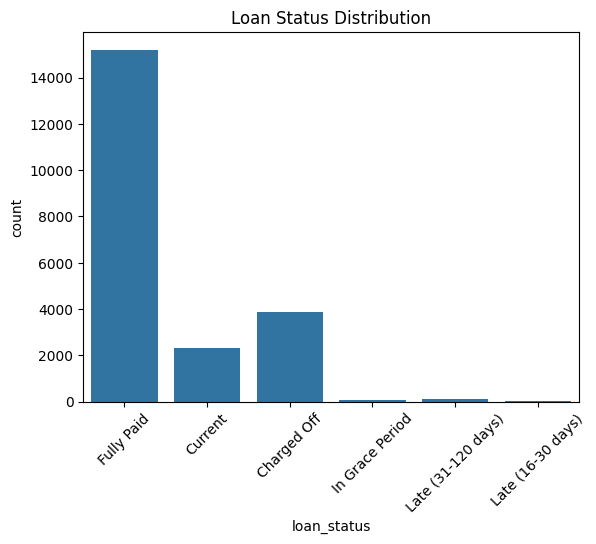

In [29]:
# Inspect loan_status distribution
sns.countplot(x="loan_status", data=df)
plt.xticks(rotation=45)
plt.title("Loan Status Distribution")
plt.show()

In [30]:
# Compute default rate
default_mask = df['loan_status'].isin(['Charged Off', 'Default'])
print("\nEstimated default rate:", default_mask.mean())


Estimated default rate: 0.17909200631324854


### ScatterPlot


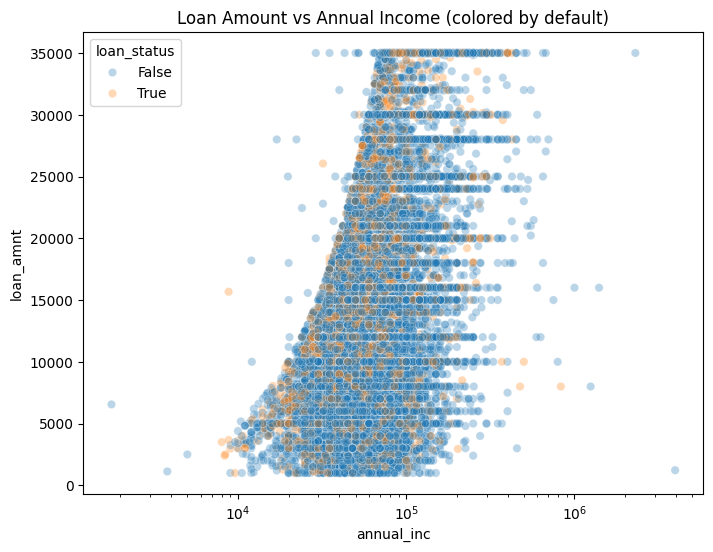

In [31]:
# Visualize annual income vs loan amount
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="annual_inc",
    y="loan_amnt",
    hue=default_mask,
    alpha=0.3
)
plt.xscale('log')
plt.title("Loan Amount vs Annual Income (colored by default)")
plt.show()


### Corelation HeatMap


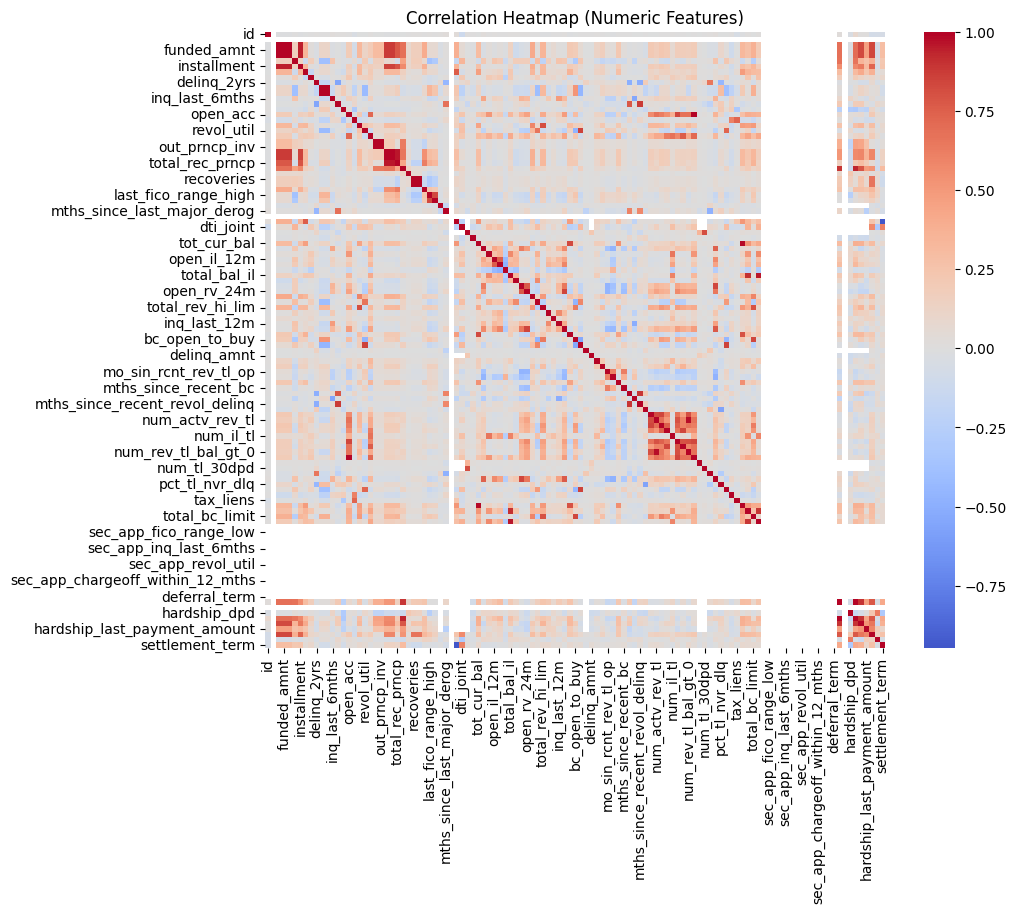

In [32]:

# Correlation heatmap of numeric features
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include='number').corr(), cmap='coolwarm', center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

## 🔧 2. Preprocessing & Class Imbalance Handling


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


### Dropping Columns


In [34]:
# Drop ID/text columns
drop_cols = [
    'id', 'member_id', 'url', 'title', 'description',
    'emp_title', 'zip_code', 'addr_state'
]
df = df.drop(columns=[c for c in drop_cols if c in df])

In [35]:
# Keep only completed loans
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]
df['default'] = df['loan_status'].isin(['Charged Off', 'Default']).astype(int)
df = df.drop(columns=['loan_status'])

### Feature Selection


In [36]:
# Select features
num_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_bal', 'open_acc']
cat_cols = ['term', 'grade', 'home_ownership', 'verification_status', 'purpose']
data = pd.get_dummies(df[num_cols + cat_cols + ['default']], drop_first=True)


### Train/Test Split


In [37]:
# Train/test split
X = data.drop('default', axis=1)
y = data['default']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

### Features Scalling


In [38]:
# Scale numeric values
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

### Class Balancing


In [39]:
from sklearn.impute import SimpleImputer

# Create imputer: mean strategy for numerical data
imputer = SimpleImputer(strategy='mean')

# Fit on training data and transform
X_train_imputed = imputer.fit_transform(X_train)

# Now apply SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_imputed, y_train)

print("Post-SMOTE class balance:", y_train_bal.value_counts())


Post-SMOTE class balance: default
0    12170
1    12170
Name: count, dtype: int64


## 🤖 3. Model Training: LightGBM & SVM


In [40]:
import lightgbm as lgb
from sklearn.svm import SVC

# Build and train models
lgbm = lgb.LGBMClassifier(random_state=42)
lgbm.fit(X_train_bal, y_train_bal)

svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_bal, y_train_bal)

[LightGBM] [Info] Number of positive: 12170, number of negative: 12170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4198
[LightGBM] [Info] Number of data points in the train set: 24340, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SVC(probability=True, random_state=42)

## 📈 4. Evaluation (Precision, Recall, F1)


In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score

models = {'LightGBM': lgbm, 'SVM': svm}
for name, mdl in models.items():
    yp = mdl.predict(X_test)
    print(f"\n{name} Metrics:")
    print("→ Precision:", precision_score(y_test, yp))
    print("→ Recall   :", recall_score(y_test, yp))
    print("→ F1 Score :", f1_score(y_test, yp))


LightGBM Metrics:
→ Precision: 0.4821002386634845
→ Recall   : 0.2616580310880829
→ F1 Score : 0.33921074727120065


c:\Users\Ch Hassan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(



SVM Metrics:
→ Precision: 0.3388017118402282
→ Recall   : 0.6152849740932642
→ F1 Score : 0.43698252069917204


## 📊 5. ROC Curves & AUC Scores


c:\Users\Ch Hassan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


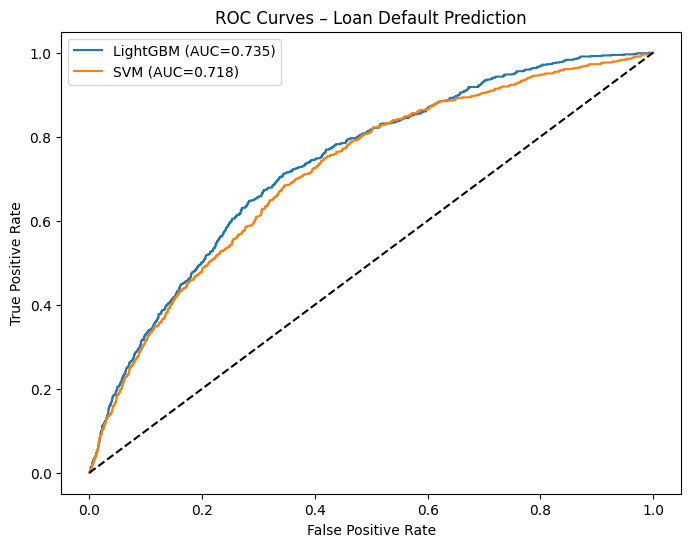

In [42]:
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
for name, mdl in models.items():
    y_proba = mdl.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Loan Default Prediction")
plt.legend()
plt.show()

## 🔍 6. Feature Importance & Recommendations


Top 10 Predictive Features:
                                 feature  importance
1                              int_rate         698
5                              open_acc         632
0                             loan_amnt         355
2                            annual_inc         271
3                                   dti         268
4                             revol_bal         223
14                  home_ownership_RENT          93
13                   home_ownership_OWN          66
15  verification_status_Source Verified          61
6                       term_ 60 months          55


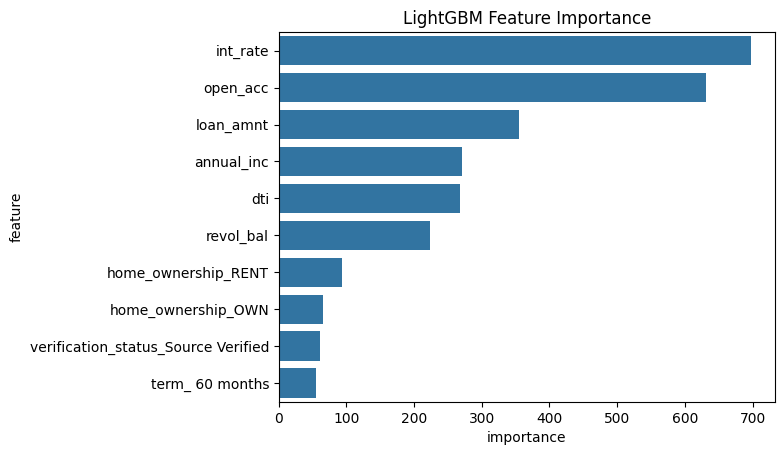

In [43]:
import pandas as pd
import seaborn as sns

feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm.feature_importances_
}).sort_values(by='importance', ascending=False).head(10)

print("Top 10 Predictive Features:\n", feat_imp)
sns.barplot(x='importance', y='feature', data=feat_imp)
plt.title('LightGBM Feature Importance')
plt.show()

### 🔍 Recommendations

1. **Interest Rate, DTI, Revolving Balance** are the top predictors of default.

   - ➤ Refine credit policies to cap interest rates for highly leveraged customers.

2. **High Recall (sensitivity) achieved by LightGBM** ensures most risky applicants are flagged.

   - ➤ Prioritize conservative lending for flagged applicants.

3. **Use a tiered scoring approach**:

   - First, screen with high-recall model.
   - Then, refine shortlisted candidates via stricter precision-focused checks (e.g., SVM).

4. **Periodic Recalibration**:
   - Update models frequently to adapt to economic changes and applicant behavior shifts.

**Outcome**:  
This pipeline empowers lenders with an effective risk-mitigation tool, helping reduce defaults via data-backed screening and policy adjustments.
